# Mesa Demo
In this file, I'll try and re-build the proof-of-concept again, this time in [Mesa](https://mesa.readthedocs.io/en/stable/overview.html).

In [446]:
# Import statements.
import mesa
import enum
import contextplot
import geopandas as gpd

In [222]:
class GeoLocation:
    """
    Physical location convenience class.

    Attributes
    ----------
    latitude: float
        Latitude of the location.
    longitude: float
        Longitude of the location.
    address: str | None
        String format of the address (for querying in Google Maps, for example)
    """

    def __init__(
        self, latitude: float, longitude: float, address: str | None = None
    ) -> None:
        """
        Constructs a new GeoLocation.

        Parameters
        ----------
        latitude: float
            GeoLocation's latitude coordinate.
        longitude: float
            GeoLocation's longitude coordinate.
        address: str, optional
            String with street address of location.
        """
        self.latitude = latitude
        self.longitude = longitude
        self.address = address

    def __format__(self, spec) -> str:
        """
        Convenience method for printing out the details of a GeoLocation.
        """
        if self.address:
            return self.address
        else:
            return f"GeoLocation at ({self.latitude:.6f}, {self.longitude:.6f})"

In [223]:
class Payload:
    def __init__(self, destination, current_location):
        self.destination = destination
        self.current_location = current_location

In [224]:
class ContainerYard(mesa.Agent):
    def __init__(self,
                 model: mesa.Model,
                 name: str,
                 requests_per_day: float,
                 request_origin,
                 location: GeoLocation | None = None):
        super().__init__(name, model)
        self.name = name
        self.location = location
        self.requests_per_day = requests_per_day
        self.request_origin = request_origin
        self.time_of_next_request = self.model.schedule.time + self._time_before_new_request_hrs()
        self.time_of_last_request =  None
        self.num_delivered_orders = 0
        self.num_requests = 0
        self.delivered_payloads = []

    def step(self):
        if self.model.schedule.time >= self.time_of_next_request:
            # If it is time for a new order, make one.
            self.create_new_order()
    
    def create_new_order(self):
        print(
            f"T = {float(self.model.schedule.time):.03f} | "
            + f"Container yard {self.name} generated a new order at {self.request_origin.name}."
        )
        # Set the time of the last request as right now.
        self.time_of_last_request = self.model.schedule.time
        # Compute how much longer until the next request.
        self.time_of_next_request = self.time_of_last_request + self._time_before_new_request_hrs()
        self.num_requests += 1
        # Put the newly created payload in the origin departure queue.
        self.request_origin.put_in_departure_queue(Payload(self, self.request_origin))
        
    def _time_before_new_request_hrs(self):
        return self.random.expovariate(self.requests_per_day / 24.0)

    def deliver_order(self, payload):
        self.num_delivered_orders += 1
        self.delivered_payloads.append(payload)

In [353]:
class RailTerminal(mesa.Agent):
    def __init__(self,
                 name: str,
                 model: mesa.Model,
                 location):
        super().__init__(name, model)
        self.name = name
        self.location = location
        
        self.arrival_queue = []
        self.departure_queue = []
    
    def step(self):
        pass

    def put_in_arrival_queue(self, payload):
        self.arrival_queue.append(payload)
    
    def put_in_departure_queue(self, payload):
        self.departure_queue.append(payload)
    
    def get_from_arrival_queue(self):
        return self.arrival_queue.pop()
    
    def get_from_departure_queue(self):
        return self.departure_queue.pop()

In [226]:
class ParallelVehicleState(enum.Enum):
    PICKING_UP = 0
    IN_TRANSIT = enum.auto()
    ARRIVING = enum.auto()
    DROPPING_OFF = enum.auto()

class ParallelVehicle(mesa.Agent):
    def __init__(self,
                 model: mesa.Model,
                 vehicle_id: int,
                 capacity: int,
                 location,
                 destination = None,
                 payload = None):
        super().__init__(f'Parallel Vehicle {vehicle_id}', model)

        self.vehicle_id = vehicle_id
        self.capacity = capacity
        self.previous_location = None
        self.current_location = location
        self.current_destination = destination
        self.current_state = ParallelVehicleState.PICKING_UP  # Start vehicle in pickup mode
        self.current_payload = []
        self.time_of_next_action = 0
        if payload:
            if isinstance(payload, list):
                self.current_payload.extend(payload)
            elif isinstance(payload, Payload):
                self.current_payload.append(payload)
    
    def step(self):
        # Only do things if we aren't currently waiting/loading/delaying/etc.
        if self.time_of_next_action <= self.model.schedule.time:
            # If we have room and there's stuff to pick up, pick it up
            match self.current_state:

                case ParallelVehicleState.PICKING_UP:
                    self.pickup_payload()
            
                # If we're all loaded up and good to go, move to the next location.
                case ParallelVehicleState.IN_TRANSIT:
                    self.move_between_terminals()
            
                # If we were in transit and are able to take an action, we have arrived!
                case ParallelVehicleState.ARRIVING:
                    self.stop_at_terminal()
            
                # If we arrived at our destination and are waiting, start unloading!
                case ParallelVehicleState.DROPPING_OFF:
                    # Otherwise, we're at our destination with stuff, drop it off!
                    self.drop_off_payload()

            
    def stop_at_terminal(self):
        self.previous_location = self.current_location
        self.current_location = self.current_destination
        self.current_destination = self.previous_location  # Tell ourselves to turn around
        print(
            f"T = {float(self.model.schedule.time):.03f} | "
            + f"Parallel Vehicle arrived at {self.current_location.name} "
            + f"({len(self.current_payload)}/{self.capacity})"
        )
        self.current_state = ParallelVehicleState.DROPPING_OFF

    def pickup_payload(self):
        if self.current_location.departure_queue:
            self.current_payload.append(self.current_location.get_from_departure_queue())
            print(
                f"T = {float(self.model.schedule.time):.03f} | "
                + f"Parallel Vehicle picked up a payload at {self.current_location.name} "
                + f"({len(self.current_payload)}/{self.capacity})"
            )
            self.time_of_next_action = self.model.schedule.time + self._time_to_load_hrs()

            # Determine transition to next state.
            if len(self.current_payload) < self.capacity :
                # If we have more space, keep picking up at next step.
                self.current_state = ParallelVehicleState.PICKING_UP
            else:
                # If we are full, then time to leave at next step.
                self.current_state = ParallelVehicleState.IN_TRANSIT
        else:
            self.current_state = ParallelVehicleState.IN_TRANSIT
    
    def drop_off_payload(self):
        if self.current_payload:
            self.current_location.put_in_arrival_queue(self.current_payload.pop())
            print(
                f"T = {float(self.model.schedule.time):.03f} | "
                + f"Parallel Vehicle dropped off a payload at {self.current_location.name} "
                + f"({len(self.current_payload)}/{self.capacity})"
            )
            self.time_of_next_action = self.model.schedule.time + self._time_to_load_hrs()
        else:
            self.time_of_next_action = self.model.schedule.time
            self.current_state = ParallelVehicleState.PICKING_UP


    def move_between_terminals(self):
        print(
            f"T = {float(self.model.schedule.time):.03f} | "
            + f"Parallel Vehicle driving from {self.current_location.name} "
            + f"to {self.current_destination.name}"
        )
        self.time_of_next_action = self.model.schedule.time + self._time_to_travel_hrs()
        self.current_state = ParallelVehicleState.ARRIVING
    
    def _time_to_load_hrs(self):
        return self.random.expovariate(0.25)

    def _time_to_travel_hrs(self):
        return self.random.uniform(5, 15)
        

In [227]:
class TruckState(enum.Enum):
    PICKING_UP = 0
    IN_TRANSIT = enum.auto()
    DROPPING_OFF = enum.auto()
    IDLE = enum.auto()


class Truck(mesa.Agent):
    def __init__(self,
                 model: mesa.Model,
                 vehicle_id: int,
                 capacity: int,
                 current_location,
                 current_payload,
                 current_destination
    ):
        super().__init__(f'Truck {vehicle_id}', model)
        self.vehicle_id = vehicle_id
        self.capacity = capacity
        self.previous_location = None
        self.current_location = current_location
        self.current_destination = current_destination
        self.current_payload = []
        if isinstance(current_payload, list):
            self.current_payload += current_payload
        elif isinstance(current_payload, Payload):
            self.current_payload.append(current_payload)
        self.time_of_next_action = self.model.schedule.time
        self.current_state = TruckState.IDLE # start in idle state
    
    def step(self):
        # First check if the agent needs to wait to act.
        if self.time_of_next_action <= self.model.schedule.time:
            match self.current_state:
                case TruckState.PICKING_UP:
                    self.pickup_payload()
                
                case TruckState.IN_TRANSIT:
                    self.stop_at_location()
                
                case TruckState.DROPPING_OFF:
                    self.drop_off_payload()
                
                case TruckState.IDLE:
                    self.move_to_destination()
    
    def move_to_destination(self):
        if self.current_payload:
            # If there's a payload loaded, go where it's supposed to go.
            self.current_destination = self.current_payload[0].destination
        self.current_state = TruckState.IN_TRANSIT
        print(
            f"T = {float(self.model.schedule.time):.03f} | "
            + f"Truck {self.vehicle_id} driving from {self.current_location.name} "
            + f"to {self.current_destination.name} ({len(self.current_payload)}/{self.capacity})"
        )
        self.time_of_next_action = self.model.schedule.time + self._time_to_travel_hrs()
                
    def drop_off_payload(self):
        if self.current_payload:
            self.current_location.deliver_order(self.current_payload.pop())
            print(
                f"T = {float(self.model.schedule.time):.03f} | "
                + f"Truck {self.vehicle_id} dropped off a payload at {self.current_location.name} "
                + f"({len(self.current_payload)}/{self.capacity})"
            )
            self.time_of_next_action = self.model.schedule.time + self._time_to_load_hrs()
        else:
            self.current_state = TruckState.PICKING_UP
    
    def pickup_payload(self):
        # This logic is a bit of a mess and I don't like it.
        if hasattr(self.current_location, 'arrival_queue'):
            if self.current_location.arrival_queue:
                if len(self.current_payload) < self.capacity:
                    self.current_payload.append(self.current_location.get_from_arrival_queue())
                    print(
                        f"T = {float(self.model.schedule.time):.03f} | "
                        + f"Truck {self.vehicle_id} picked up a payload at {self.current_location.name} "
                        + f"({len(self.current_payload)}/{self.capacity})"
                    )
                    self.time_of_next_action = self.model.schedule.time + self._time_to_load_hrs()
                
                if len(self.current_payload) < self.capacity:
                    # Keep picking up if we can
                    self.current_state = TruckState.PICKING_UP
                else:
                    # Otherwise move to idle
                    self.current_state = TruckState.IDLE
            else:
                self.current_state = TruckState.PICKING_UP
        else:
            self.current_state = TruckState.IDLE
    
    def stop_at_location(self):
        self.previous_location = self.current_location
        self.current_location = self.current_destination
        # Tell us to turn around for now!
        self.current_destination = self.previous_location
        self.current_state = TruckState.DROPPING_OFF
        print(
            f"T = {float(self.model.schedule.time):.03f} | "
            + f"Truck {self.vehicle_id} arrived at {self.current_location.name} "
            + f"({len(self.current_payload)}/{self.capacity})"
        )
    
    def _time_to_load_hrs(self):
        return self.random.expovariate(0.25)
    
    def _time_to_travel_hrs(self):
        return self.random.uniform(0.5, 3.0)

In [456]:
def sum_transit(model: mesa.Model):
    transit_states = (agent.current_state == ParallelVehicleState.IN_TRANSIT or agent.current_state == TruckState.IN_TRANSIT for agent in model.schedule.agents if hasattr(agent, 'current_state'))
    return sum(transit_states)

def sum_delivered_payloads(model: mesa.Model):
    delivered_payloads = (len(agent.delivered_payloads) for agent in model.schedule.agents if hasattr(agent, 'delivered_payloads'))
    return sum(delivered_payloads)

def compute_usage(agent: mesa.Agent):
    if hasattr(agent, 'capacity') and hasattr(agent, 'current_payload'):
        return len(agent.current_payload)/agent.capacity

def compute_departure_queue_length(agent: mesa.Agent):
    if hasattr(agent, 'departure_queue'):
        return len(agent.departure_queue)

def compute_arrival_queue_length(agent: mesa.Agent):
    if hasattr(agent, 'arrival_queue'):
        return len(agent.arrival_queue)

def get_location(agent: mesa.Agent):
    lat, lon = None, None
    
    if hasattr(agent, 'current_location'):
        lat, lon = agent.current_location.location.latitude, agent.current_location.location.longitude
    elif hasattr(agent, 'location'):
        lat, lon = agent.location.latitude, agent.location.longitude
    
    return (lat, lon)

class Model(mesa.Model):
    def __init__(self, num_container_yards):
        super().__init__()
        self.schedule = mesa.time.RandomActivation(self)
        self.savannah_terminal = RailTerminal("Savannah",
                                              self,
                                              GeoLocation(
                                              latitude=32.0746968,
                                              longitude=-81.1218618,
                                              address="1880 W Gwinnett St, Savannah, GA 31415",
                                              ))
        self.cordele_terminal = RailTerminal("Cordele",
                                             self,
                                             GeoLocation(
                                             latitude=31.968125,
                                             longitude=-83.7420403,
                                             address="2902 E 13th Ave, Cordele, GA 31015",
                                             )
                                             )
        
        self.schedule.add(self.savannah_terminal)
        self.schedule.add(self.cordele_terminal)

        self.parallel_vehicle = ParallelVehicle(self, 0, 12, self.savannah_terminal, self.cordele_terminal)
        self.schedule.add(self.parallel_vehicle)

        self.container_yards = gpd.read_file('./data/SavannahCordeleNbrs.geojson').apply(self.create_container_yards, axis=1).tolist()
        self.trucks = []
        for i, cy in enumerate(self.container_yards):
            new_truck = Truck(self, i, 1, cy, None, self.cordele_terminal)
            self.trucks.append(new_truck)

        for cy, truck in zip(self.container_yards, self.trucks):
            self.schedule.add(cy)
            self.schedule.add(truck)

        self.datacollector = mesa.DataCollector(
            model_reporters={'Num In Transit': sum_transit,
                             'Payloads Delivered': sum_delivered_payloads},
            agent_reporters={'Usage': compute_usage,
                             'Departure Queue Length': compute_departure_queue_length,
                             'Arrival Queue Length': compute_arrival_queue_length,
                             'Location': get_location}
        )

    def create_container_yards(self, container_yard: gpd.GeoSeries):
        yard_location = GeoLocation(latitude=container_yard[['LATITUDE']].item(),
                                    longitude=container_yard[['LONGITUDE']].item(),
                                    address=container_yard[['Address']].item())
        return ContainerYard(self,
                             name=container_yard[['Corp Name']].item(),
                             requests_per_day=1.5,
                             request_origin=self.savannah_terminal,
                             location=yard_location
                             )
    
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [457]:
num_container_yards = 3

test_model = Model(num_container_yards)

In [458]:
DAYS_TO_SIMULATE = 365

for _ in range(DAYS_TO_SIMULATE * 24):
    test_model.step()

T = 0.000 | Truck 3 driving from Perdue Farms to Cordele (0/1)
T = 0.000 | Truck 2 driving from Blue Bird Corp to Cordele (0/1)
T = 0.000 | Truck 4 driving from Orgill, Inc. to Cordele (0/1)
T = 0.000 | Truck 0 driving from CORDELE INTERMODAL SERVICES to Cordele (0/1)
T = 0.000 | Truck 1 driving from XPO - OGLETHORPE to Cordele (0/1)
T = 1.000 | Truck 2 arrived at Cordele (0/1)
T = 1.000 | Parallel Vehicle driving from Savannah to Cordele
T = 2.000 | Truck 4 arrived at Cordele (0/1)
T = 3.000 | Truck 1 arrived at Cordele (0/1)
T = 3.000 | Truck 3 arrived at Cordele (0/1)
T = 3.000 | Truck 0 arrived at Cordele (0/1)
T = 4.000 | Container yard Blue Bird Corp generated a new order at Savannah.
T = 5.000 | Container yard CORDELE INTERMODAL SERVICES generated a new order at Savannah.
T = 10.000 | Container yard XPO - OGLETHORPE generated a new order at Savannah.
T = 13.000 | Parallel Vehicle arrived at Cordele (0/12)
T = 16.000 | Parallel Vehicle driving from Cordele to Savannah
T = 18.000 

In [459]:
agents_df = test_model.datacollector.get_agent_vars_dataframe()
agents_df.head(20)

Usage  Departure Queue Length  \
Step AgentID                                                      
0    Savannah                       NaN                     0.0   
     Cordele                        NaN                     0.0   
     Parallel Vehicle 0             0.0                     NaN   
     CORDELE INTERMODAL SERVICES    NaN                     NaN   
     Truck 0                        0.0                     NaN   
     XPO - OGLETHORPE               NaN                     NaN   
     Truck 1                        0.0                     NaN   
     Blue Bird Corp                 NaN                     NaN   
     Truck 2                        0.0                     NaN   
     Perdue Farms                   NaN                     NaN   
     Truck 3                        0.0                     NaN   
     Orgill, Inc.                   NaN                     NaN   
     Truck 4                        0.0                     NaN   
1    Truck 3                        0.0                     NaN   
     Truck 2                        0.0                     NaN   
     Orgill, Inc.                   NaN                     NaN   
     Savannah                       NaN                     0.0   
     CORDELE INTERMODAL SERVICES    NaN                     NaN   
     Cordele                        NaN                     0.0   
     Truck 4                        0.0                     NaN   

                                  Arrival Queue Length  \
Step AgentID                                             
0    Savannah                                      0.0   
     Cordele                                       0.0   
     Parallel Vehicle 0                            NaN   
     CORDELE INTERMODAL SERVICES                   NaN   
     Truck 0                                       NaN   
     XPO - OGLETHORPE                              NaN   
     Truck 1                                       NaN   
     Blue Bird Corp                                NaN   
     Truck 2                                       NaN   
     Perdue Farms                                  NaN   
     Truck 3                                       NaN   
     Orgill, Inc.                                  NaN   
     Truck 4                                       NaN   
1    Truck 3                                       NaN   
     Truck 2                                       NaN   
     Orgill, Inc.                                  NaN   
     Savannah                                      0.0   
     CORDELE INTERMODAL SERVICES                   NaN   
     Cordele                                       0.0   
     Truck 4                                       NaN   

                                                   Location  
Step AgentID                                                 
0    Savannah                     (32.0746968, -81.1218618)  
     Cordele                       (31.968125, -83.7420403)  
     Parallel Vehicle 0           (32.0746968, -81.1218618)  
     CORDELE INTERMODAL SERVICES    (31.974062, -83.782882)  
     Truck 0                        (31.974062, -83.782882)  
     XPO - OGLETHORPE               (32.275799, -84.054337)  
     Truck 1                        (32.275799, -84.054337)  
     Blue Bird Corp                 (32.561622, -83.880635)  
     Truck 2                        (32.561622, -83.880635)  
     Perdue Farms                   (32.442154, -83.633654)  
     Truck 3                        (32.442154, -83.633654)  
     Orgill, Inc.                   (31.422102, -83.508751)  
     Truck 4                        (31.422102, -83.508751)  
1    Truck 3                        (32.442154, -83.633654)  
     Truck 2                        (32.561622, -83.880635)  
     Orgill, Inc.                   (31.422102, -83.508751)  
     Savannah                     (32.0746968, -81.1218618)  
     CORDELE INTERMODAL SERVICES    (31.974062, -83.782882)  
     Cordele                       (31.968

In [460]:
agents_df['ARRIVAL_QUEUE_SIZE_AVG'] = agents_df.groupby('AgentID')['Arrival Queue Length'].transform(lambda x: x.expanding().mean())
agents_df['DEPARTURE_QUEUE_SIZE_AVG'] = agents_df.groupby('AgentID')['Departure Queue Length'].transform(lambda x : x.expanding().mean())

In [462]:
model_df = test_model.datacollector.get_model_vars_dataframe()
model_df.head(20)

,Num In Transit,Payloads Delivered
0,0,0
1,6,0
2,4,0
3,3,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


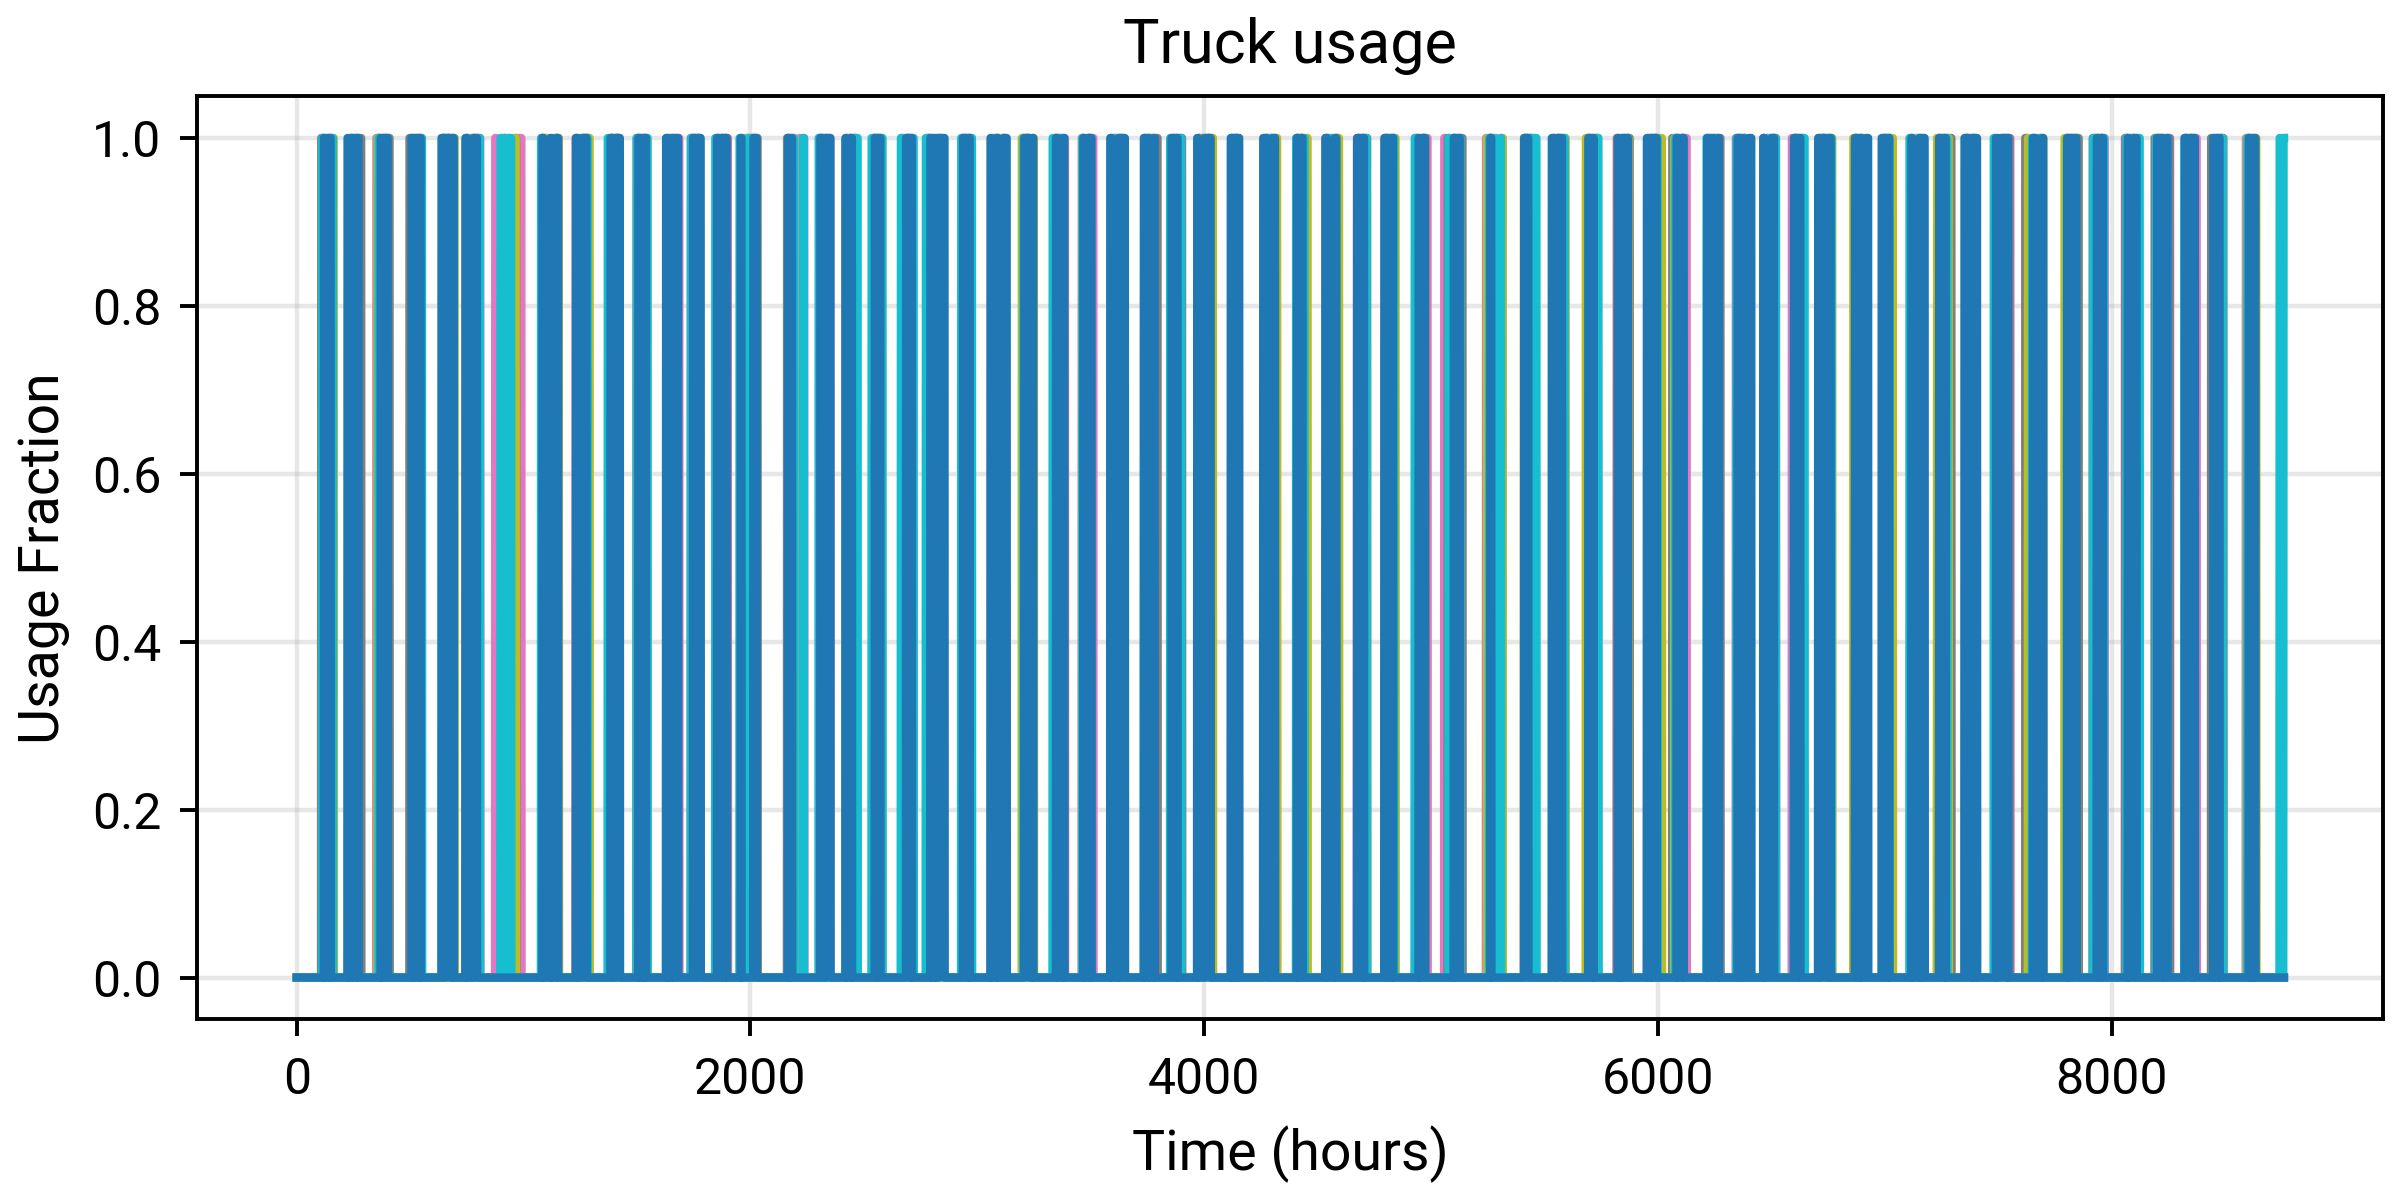

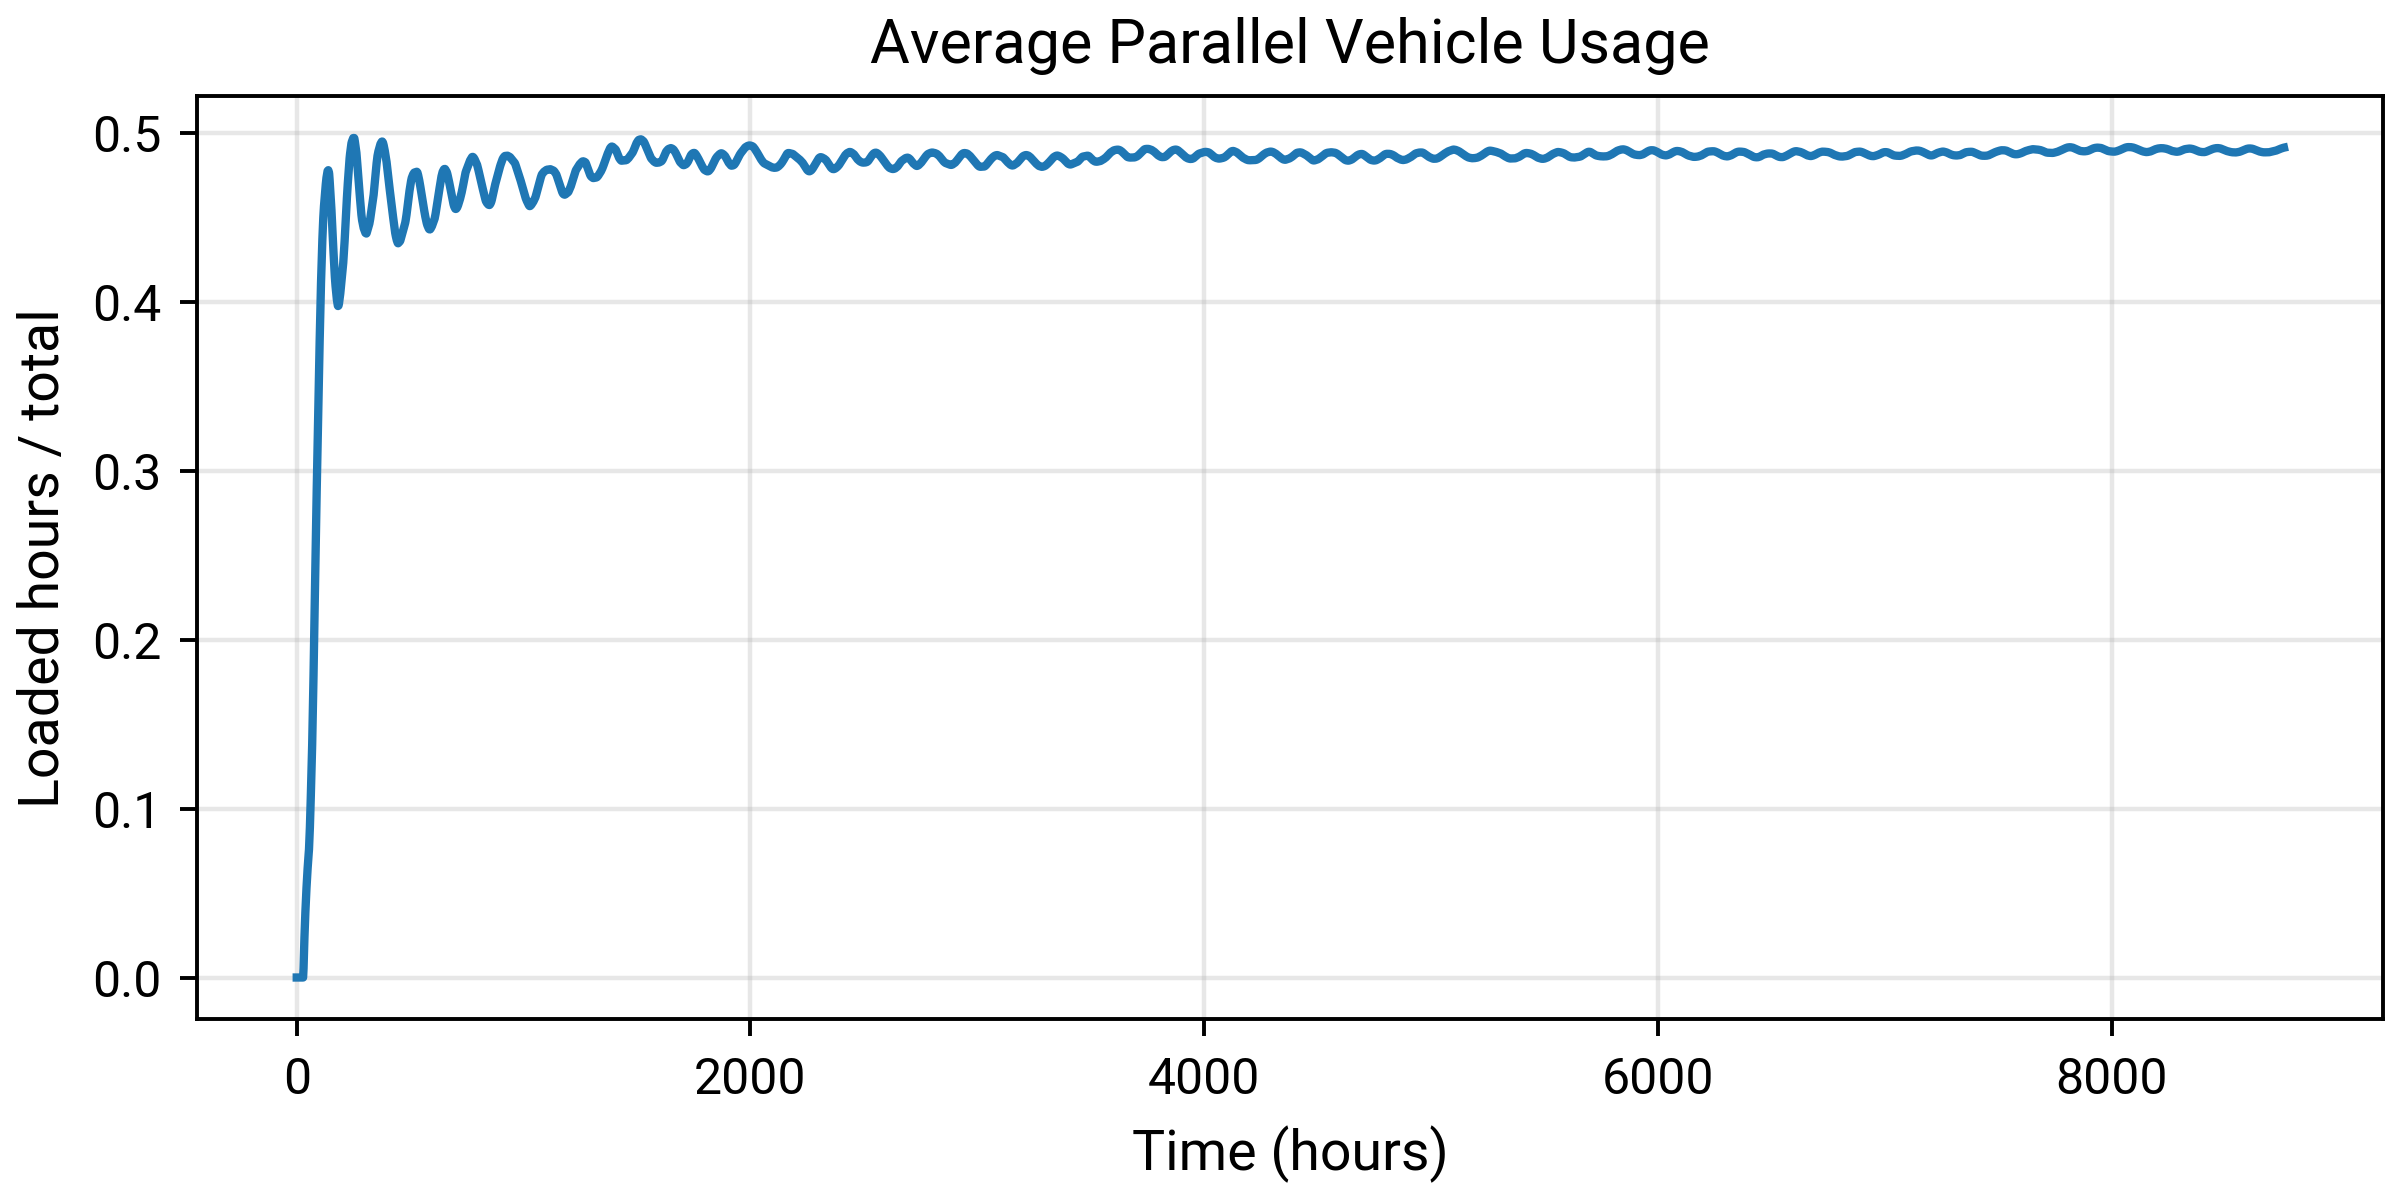

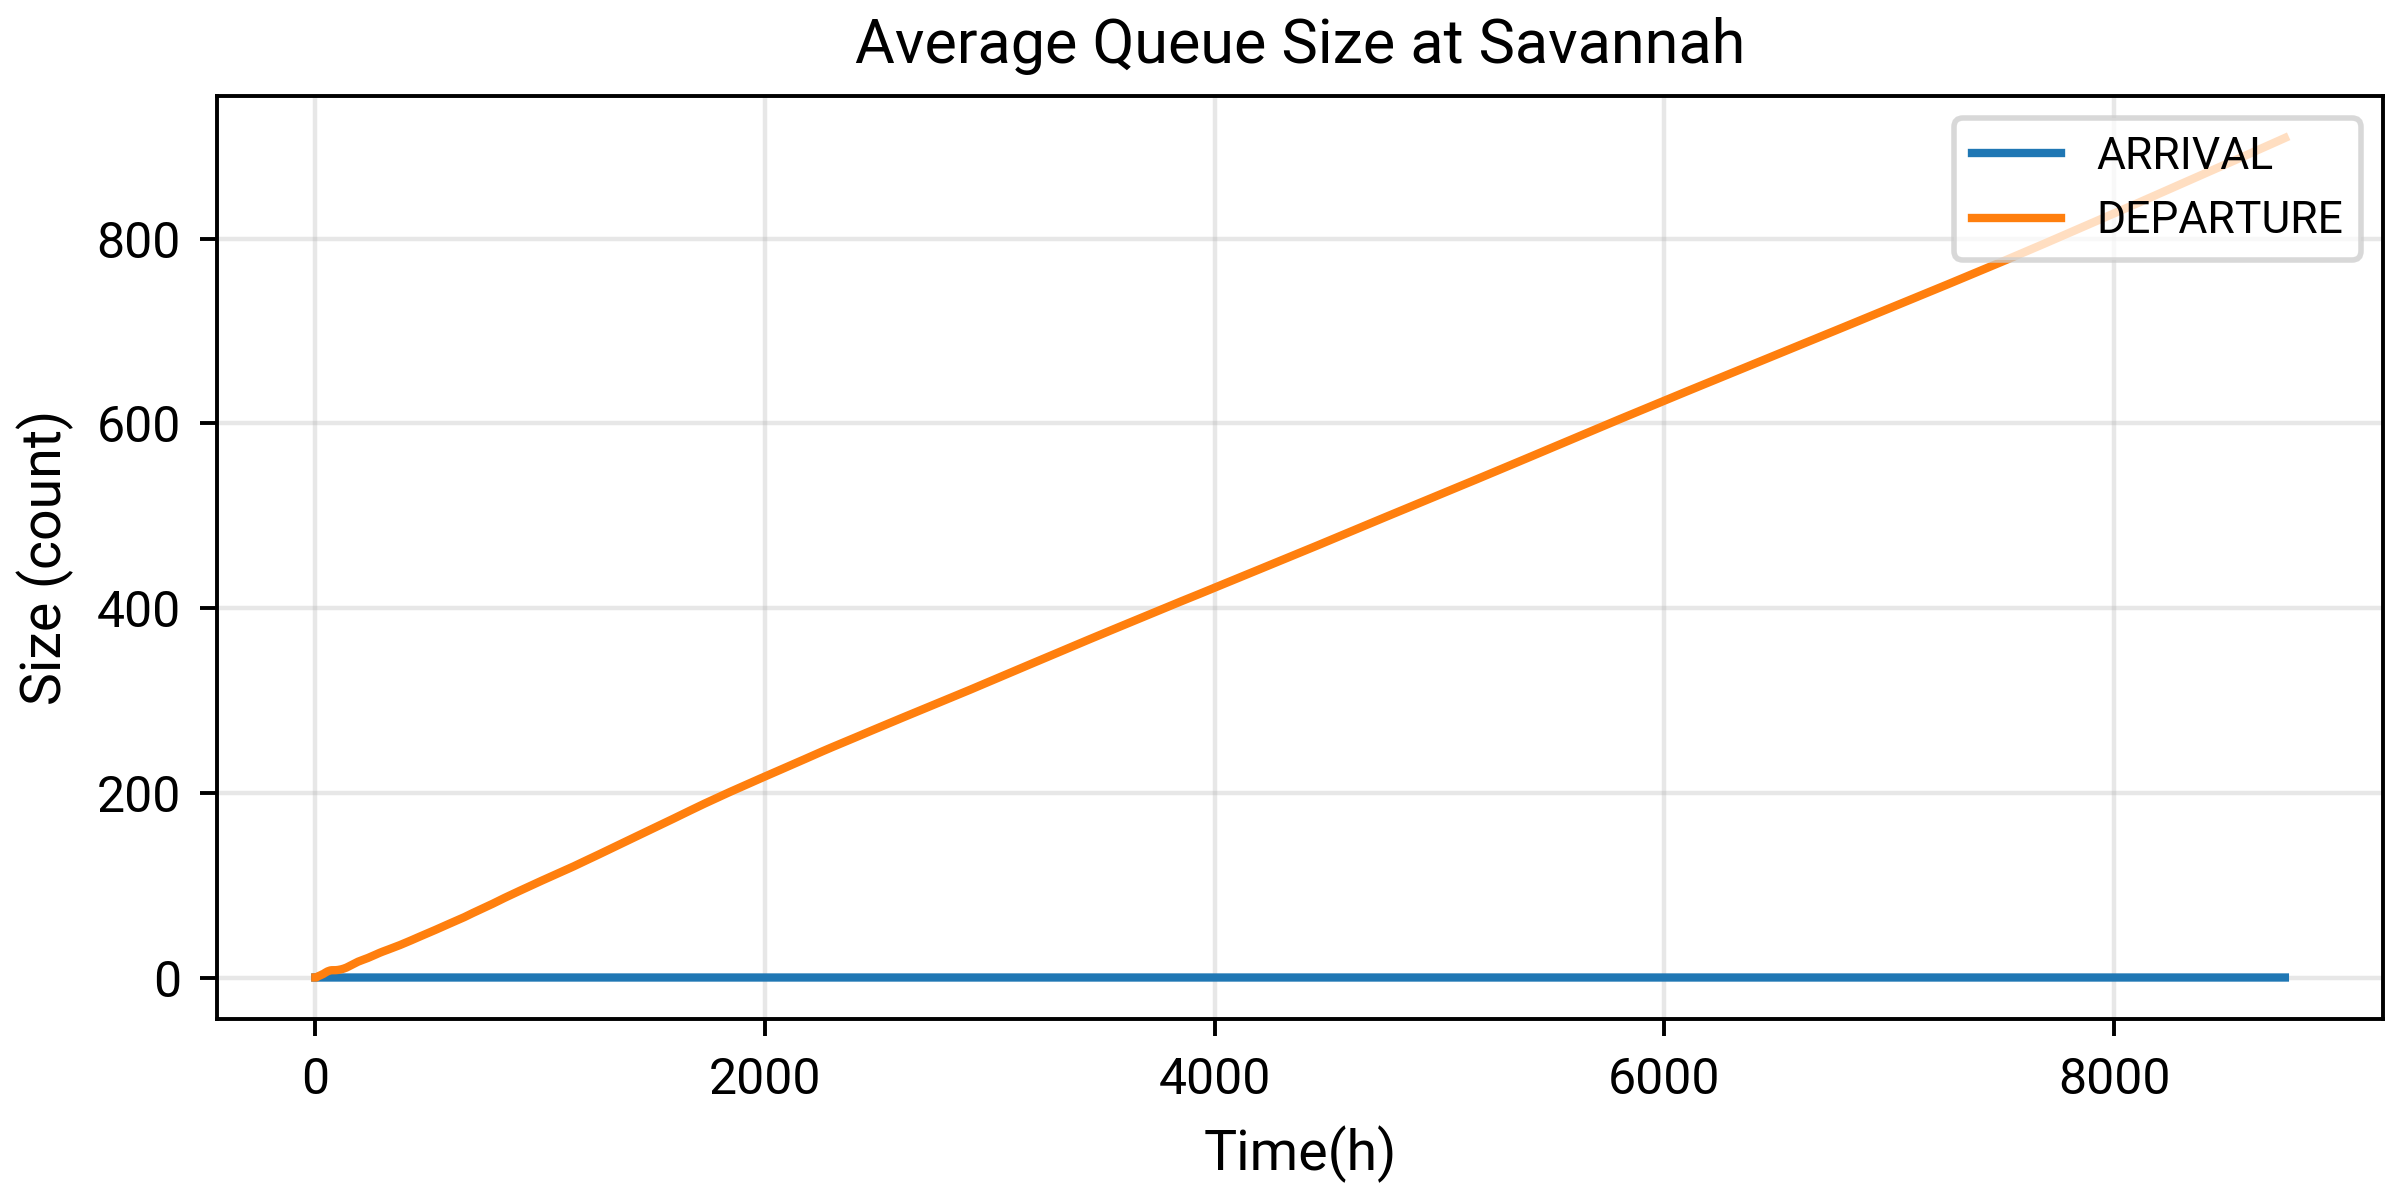

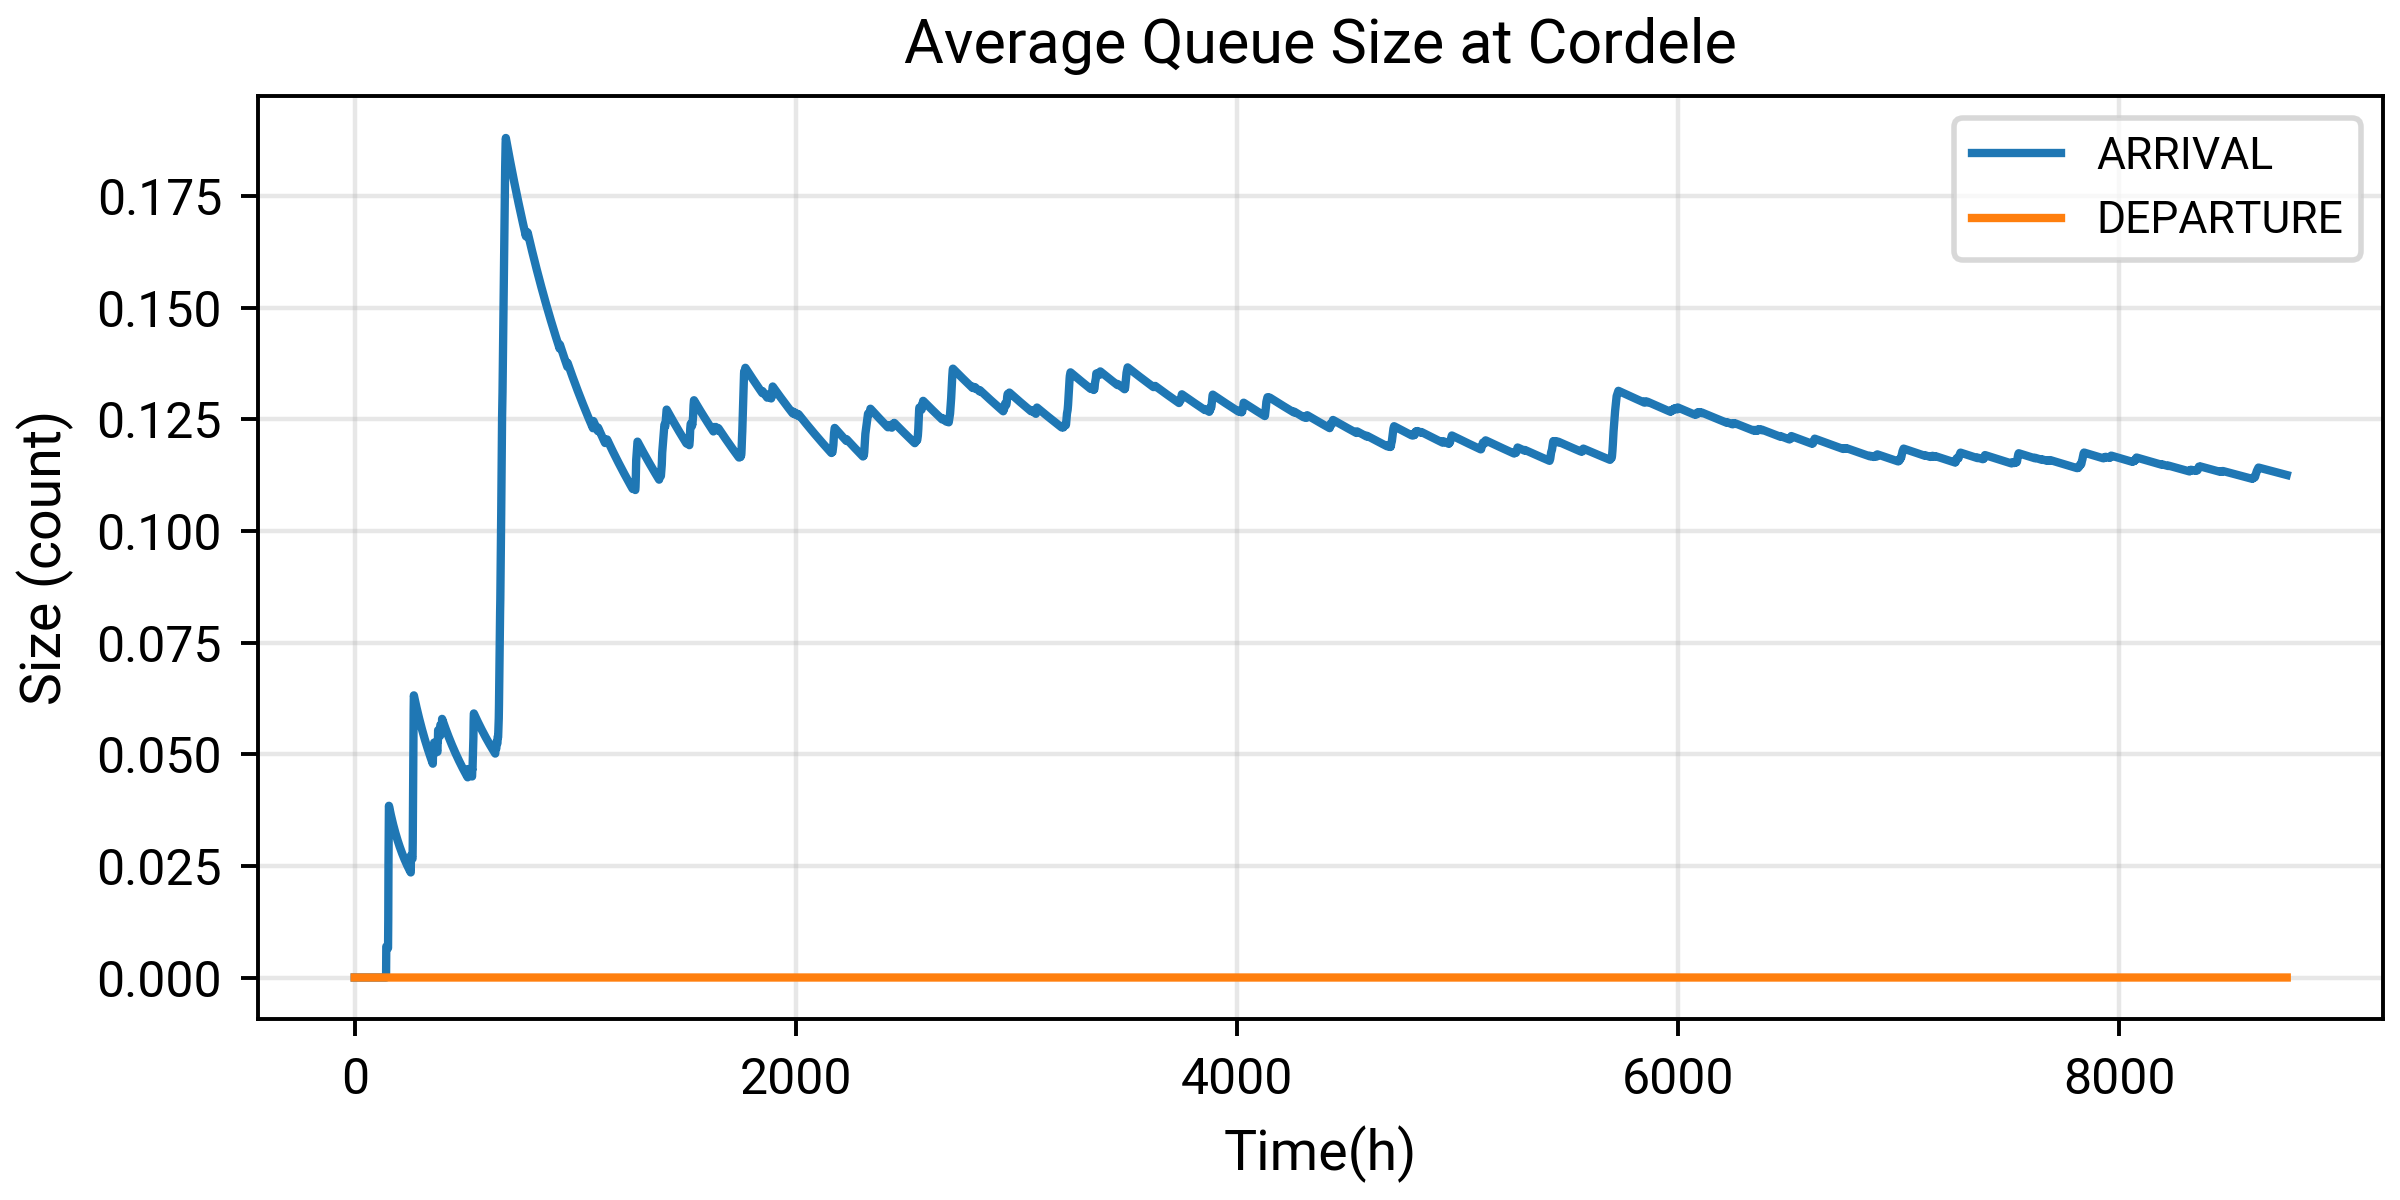

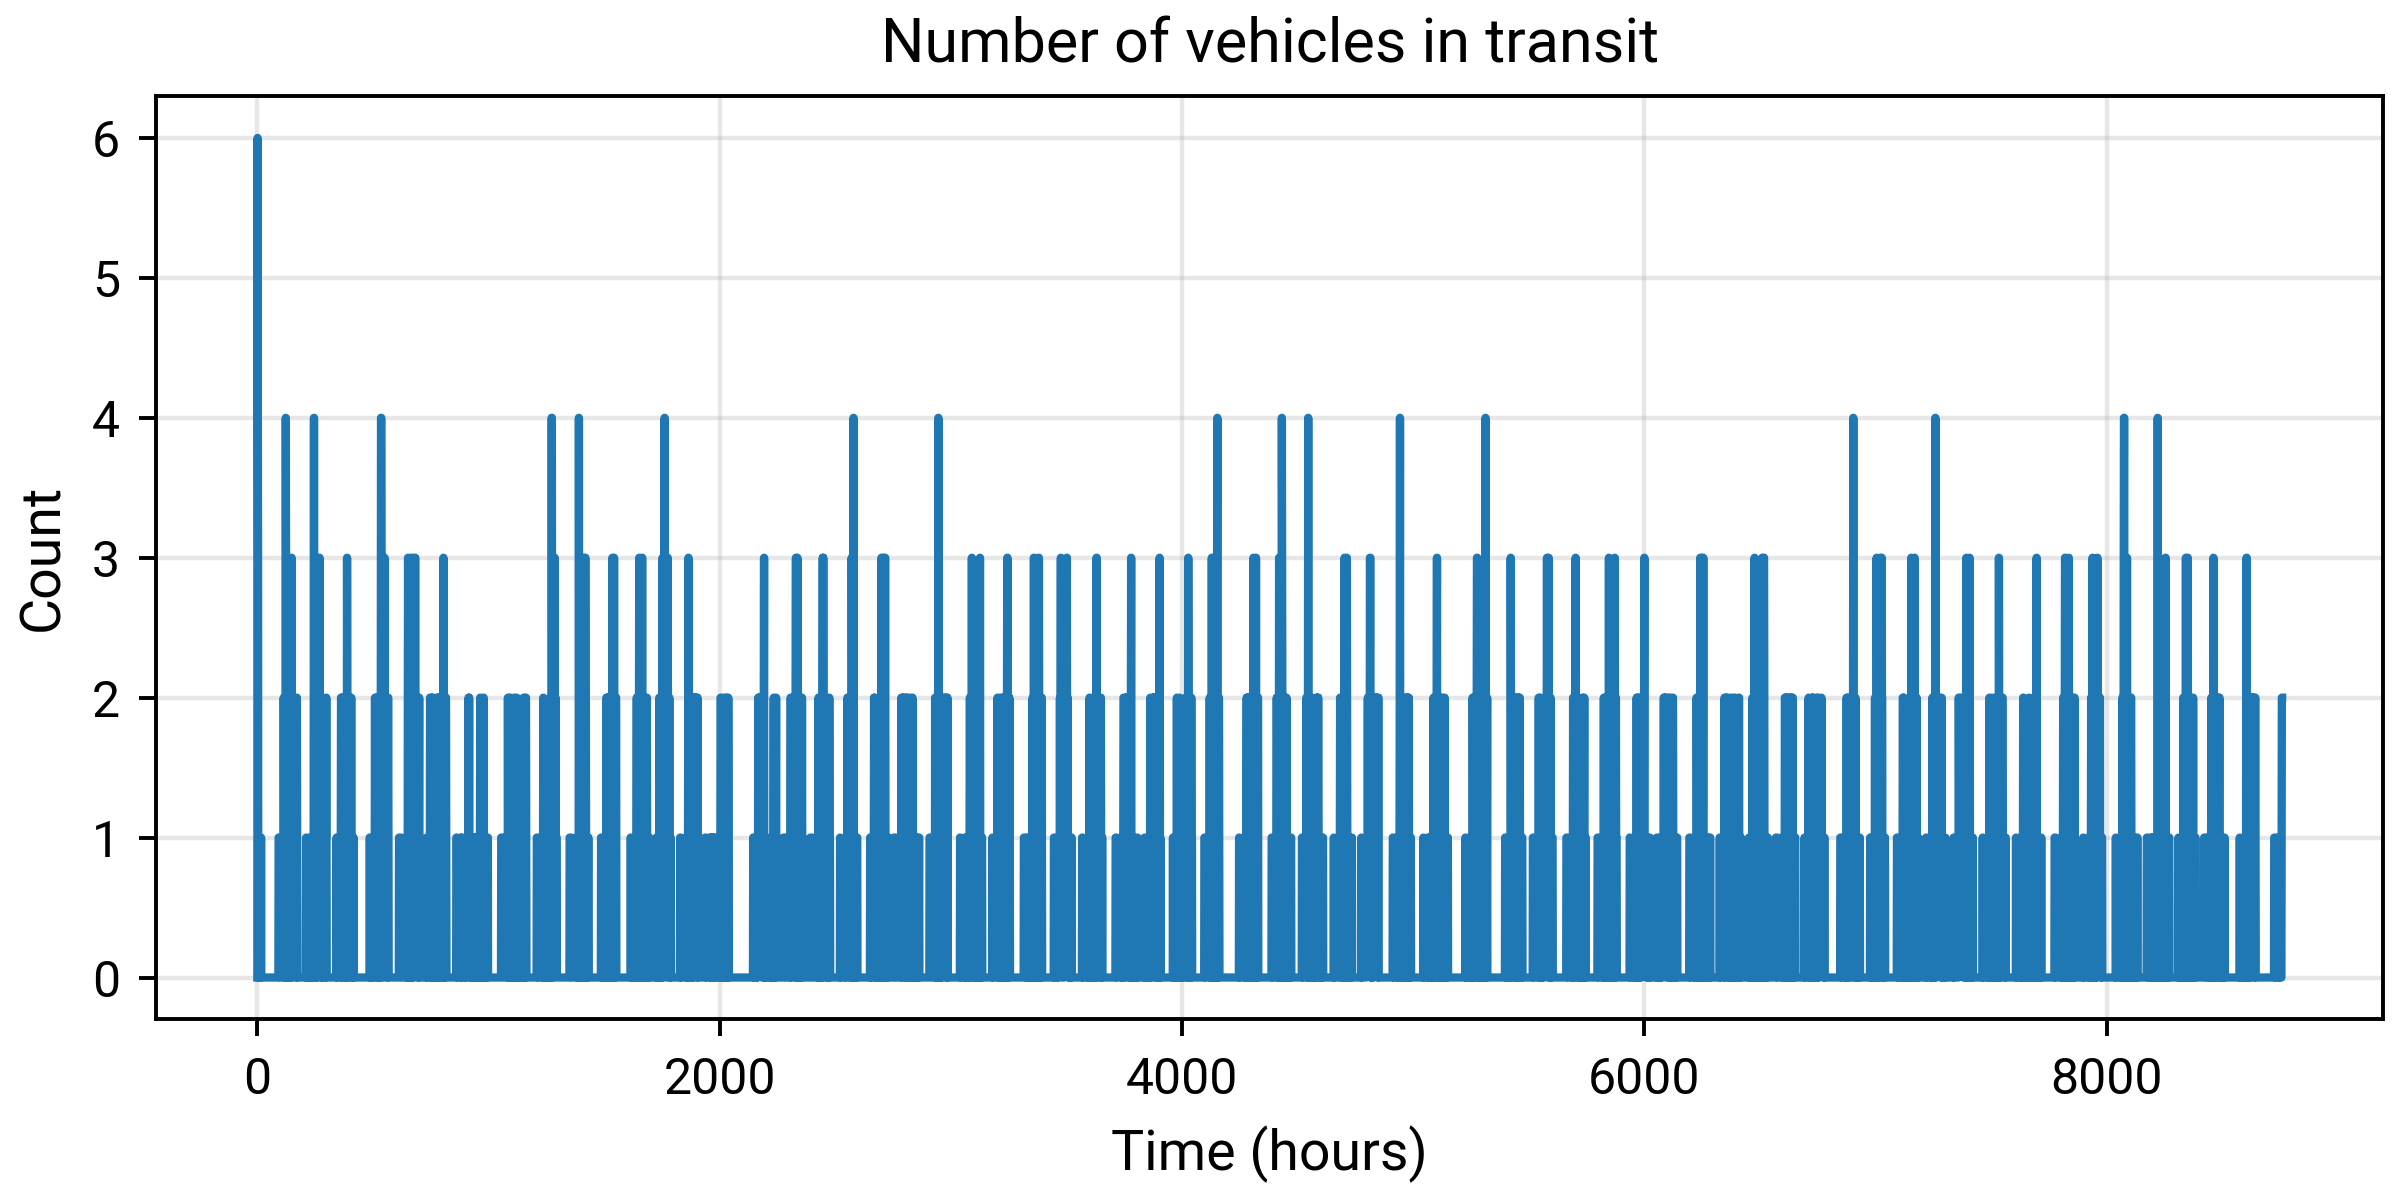

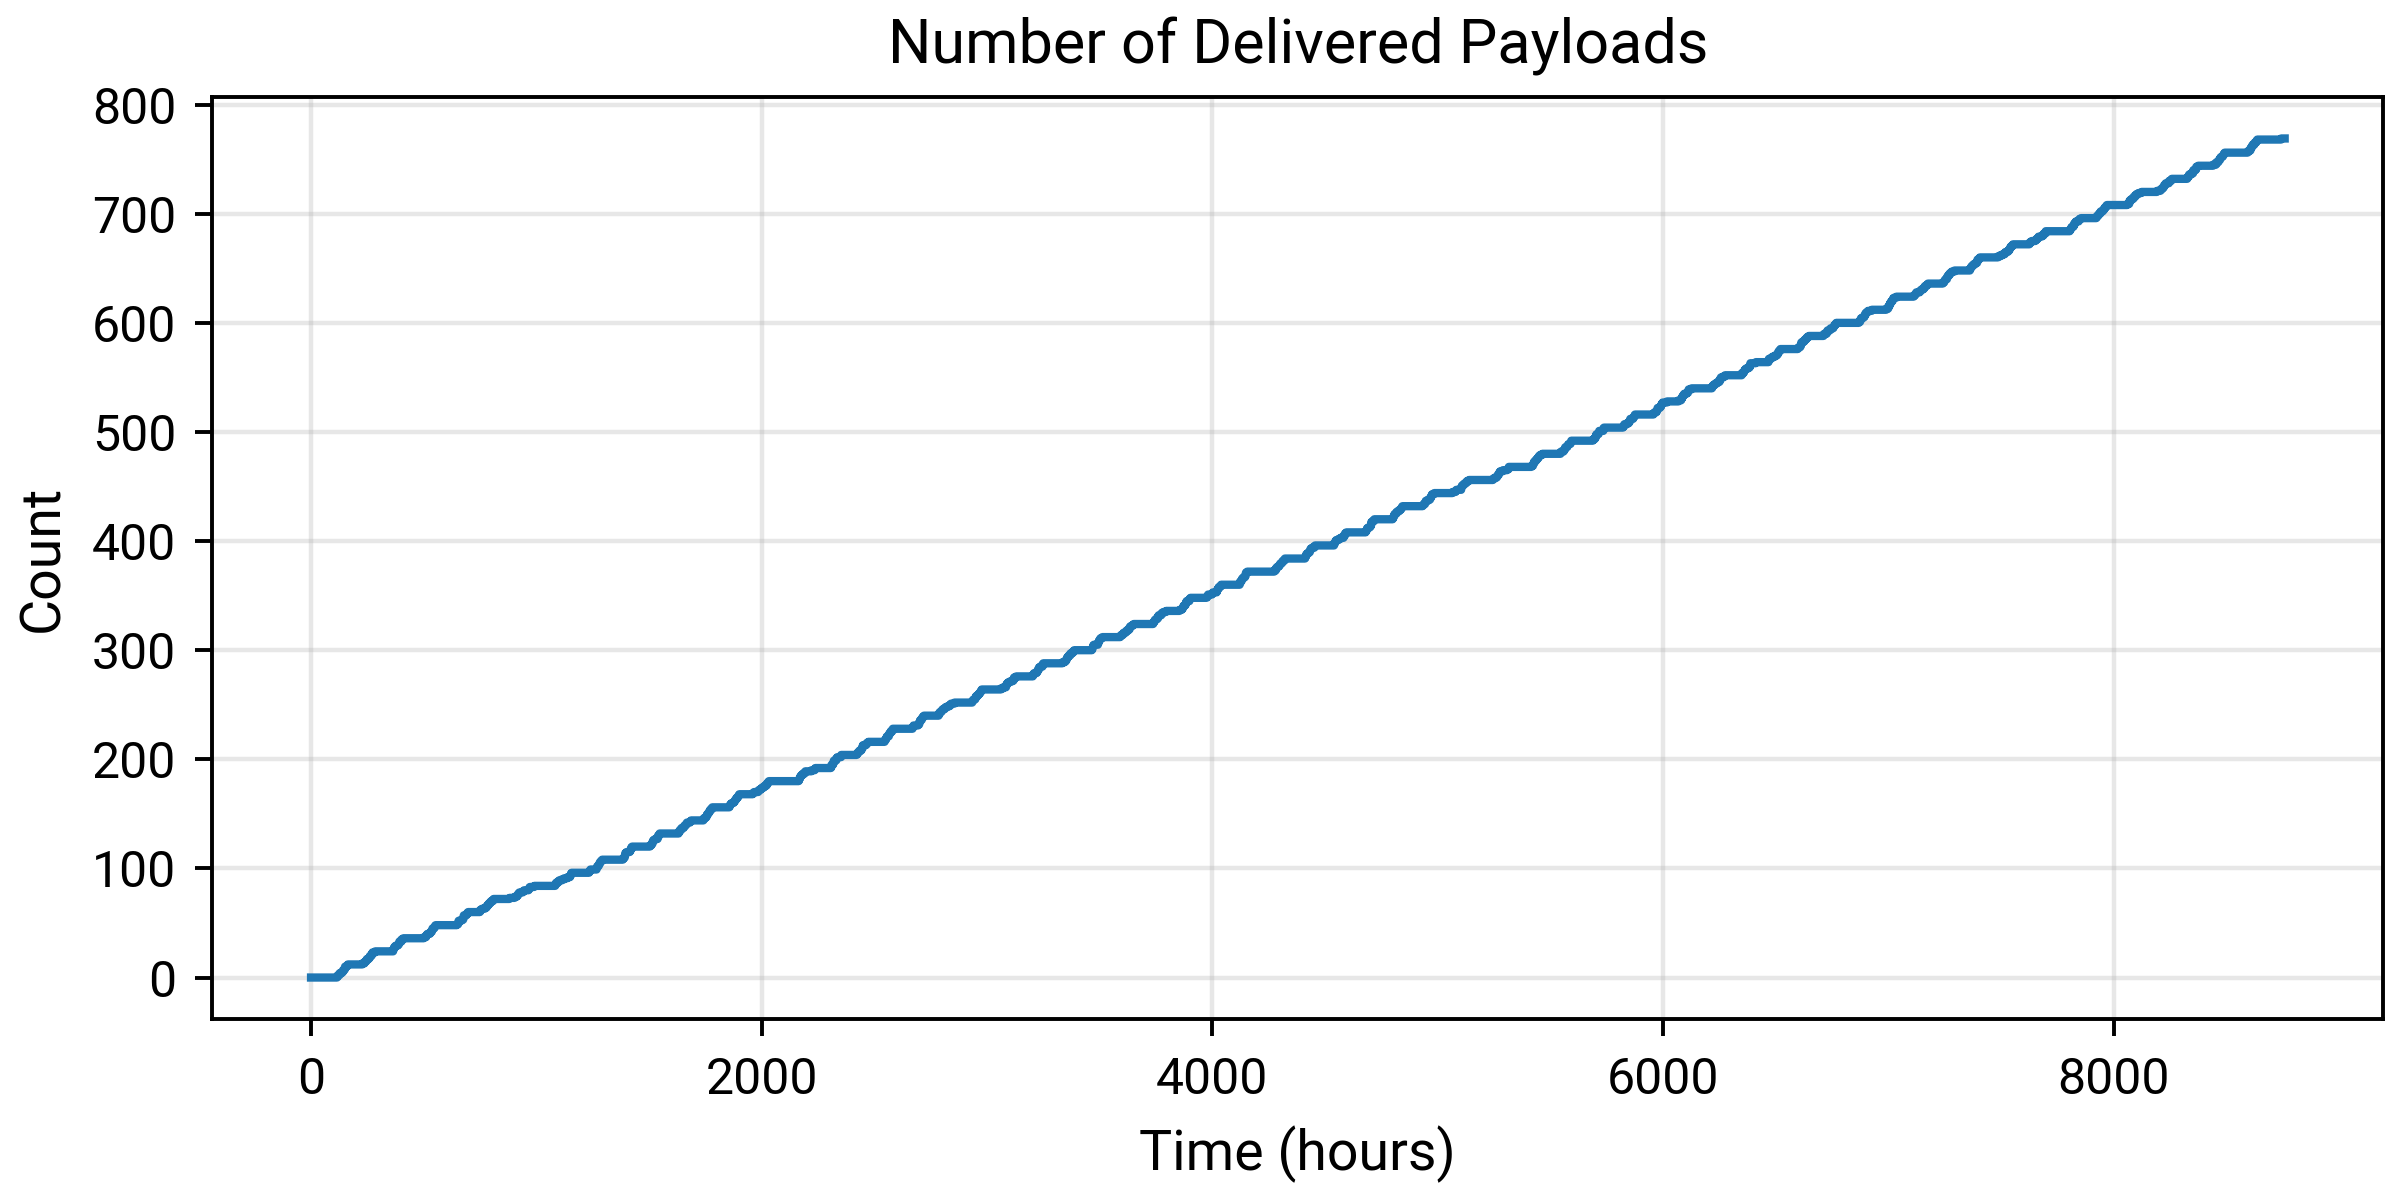

In [463]:
contextplot.set_defaults()
with contextplot.context_plot() as cp:
    for agent, data in agents_df.groupby('AgentID'):
        if agent != 'Parallel Vehicle 0':
            cp.ax.plot(data.index.get_level_values('Step'), data['Usage'])
    # cp.ax.plot(pv_use.index, pv_use['Usage'])
    cp.ax.set(title='Truck usage', xlabel='Time (hours)', ylabel='Usage Fraction')

with contextplot.context_plot() as cp:
    cp.ax.plot(agents_df.xs('Parallel Vehicle 0', level='AgentID').index, agents_df.xs('Parallel Vehicle 0', level='AgentID')['Usage'].expanding().mean())
    cp.ax.set(title='Average Parallel Vehicle Usage', xlabel='Time (hours)', ylabel='Loaded hours / total')

for terminal in ('Savannah', 'Cordele'):
    with contextplot.context_plot() as cp:
        for arrdep in ('ARRIVAL', 'DEPARTURE'):
            cp.ax.plot(agents_df.xs(terminal, level='AgentID').index, agents_df.xs(terminal, level='AgentID')[f'{arrdep}_QUEUE_SIZE_AVG'],label=arrdep)
        cp.ax.set(title=f'Average Queue Size at {terminal}', xlabel='Time(h)', ylabel='Size (count)')
        cp.ax.legend()

with contextplot.context_plot() as cp:
    cp.ax.plot(model_df.index, model_df['Num In Transit'])
    cp.ax.set(xlabel='Time (hours)', ylabel='Count', title='Number of vehicles in transit')

with contextplot.context_plot() as cp:
    cp.ax.plot(model_df.index, model_df['Payloads Delivered'])
    cp.ax.set(xlabel='Time (hours)', ylabel='Count', title='Number of Delivered Payloads')